### **Model Building**

**Background**
- Build and train a churn pipeline that evaluates several classification estimators
- Recall is a critical metric in the telecom industry, and so model evaluation efforts will focus exclusively on optimising recall
  - Why optimise recall?
     - Higher cost of false negatives than false positives
     - More expensive to replace a customer than retain an existing one (up to 5-10 times) through targeted retention efforts

**Goal**
- Model Building: Build a robust pipeline that handles class imbalance, encodes and scales data, performs cross-validation, tunes hyperparameters and returns calibrated probabilities
- Model Evaluation: Achieve Recall >= 0.8

In [157]:
import pandas as pd
import numpy as np
import os
import logging
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import joblib

In [159]:
# Set up logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [161]:
class ChurnClassifier:
    def __init__(self, logger, path):
        self.logger = logger or logging.getLogger(__name__)
        self.path = path
        self.random_state = 42
        self.data = None
        self.preprocessor = None

    def load_data(self):
        try:
            # Read in pre-processed csv into a dataframe
            parent_path = os.path.dirname(os.getcwd())
            data = pd.read_csv(os.path.join(parent_path, self.path))
            self.logger.info(f'CSV data from {path} loaded into dataframe successfully: {data.shape}')
        except Exception as err:
            self.logger.exception(f'Error whilst reading csv data into a dataframe: {err}')
        return data

    def split_train_test_data(self):
        try: 
            self.data = self.load_data()
            X = self.data.drop('Exited', axis=1)
            y = self.data['Exited']
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=self.random_state)
        except Exception as err:
            self.logger.exception(f'Error during train test split: {err}')

        return X_train, X_test, y_train, y_test

    def preprocess_data(self):
        # Identify categorical and numerical variables to undergo encoding and scaling (respectively) - Exclude columns which will 
        try:
            cat_vars = self.data.select_dtypes(include=['object']).columns.to_list()
        
            # Numerical variables excluding columns which will not be subject to scaling
            num_df = self.data.select_dtypes(include=['number'])
            num_vars = num_df.loc[:,~num_df.isin([0,1]).all()].columns.to_list()
    
            # Construct the preprocessor
            preprocessor = ColumnTransformer([('encoder', OneHotEncoder(), cat_vars),
                                      ('scaler' , StandardScaler(), num_vars)],
                                      remainder = 'passthrough')
            self.logger.info('Data preprocessing complete')
        except Exception as err:
            self.logger.Exception(f'Error during preprocessing: {err}')
        
        return preprocessor
        
    def build_pipeline(self, model):
        try:
            # Call the 'preprocess_data' function to return the preprocessor required to build the pipeline
            self.preprocessor = self.preprocess_data()
            pipeline = Pipeline(steps=[('preprocessor' , self.preprocessor),
                                   ('model', model)])
            self.logger.info('Pipeline built successfully')
        except Exception as err:
            self.logger.Exception(f'Error during pipeline build: {err}')
            
        return pipeline

    def train_pipeline(self, X_train, y_train):
        # Set class_weight = 'balanced' or calculate scale_pos_weight to assign a higher weight to the positive class
        scale_pos_weight = round(sum(y_train == 0) / sum(y_train == 1))
        models = {'LogisticRegression' : LogisticRegression(random_state = self.random_state, class_weight='balanced'),
                  'RandomForestClassifier': RandomForestClassifier(random_state = self.random_state,class_weight='balanced'),
                  'SVM': SVC(random_state = self.random_state, class_weight='balanced'),
                  'XGB': XGBClassifier(random_state = self.random_state, scale_pos_weight=scale_pos_weight)}

        trained_models = {}
        for model, classifier in models.items():
            # Construct pipeline for each classifier
            pipeline = self.build_pipeline(classifier)
            self.logger.info(f'Pipeline built for {model}')
        
            # Carry out Cross Validation
            cv = StratifiedKFold()
            scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring = 'recall')
            print(f"{model} - Mean CV Score: {scores.mean()}")
    
            # Train model using the entire training dataset
    
            pipeline.fit(X_train, y_train)

            # Store each pipeline in a dictionary
            trained_models[model] = pipeline
        
        self.logger.info('All models trained successfully')

        return trained_models

    def evaluate_models(self, X_test, y_test, trained_models):
        classifiers = []
        for model, pipeline in trained_models.items():
            y_pred = pipeline.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            classifiers.append([model, accuracy, precision, recall, f1])
        
        # Output model results into a dataframe
        columns = ['Classifier', 'Accuracy', 'Precision', 'Recall' , 'F1_Score']
        result = pd.DataFrame(data = classifiers, columns = columns)

        return result

    def optimise_best_model(self, X_train, y_train, X_test, y_test, model, param_grid):
        # Perform hyperparameter tuning using GridSearch to optimise the model for recall
        cv = StratifiedKFold()
        pipeline = self.build_pipeline(model)
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='recall', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        optimal_model = grid_search.best_estimator_

        # Evaluate the model on test data
        y_pred = optimal_model.predict(X_test)

        print(classification_report(y_test, y_pred))

        
        return optimal_model, y_pred

    def calibrate_classifier(self, X_train, y_train, X_test, model):
        # Instantiate the 'CalibratedClassifierCV' class, passing in the base estimator
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid')

        # Fit the calibrated model
        calibrated_model.fit(X_train, y_train)
        
        # Return the calibrated probabilities
        y_proba = calibrated_model.predict_proba(X_test)[:,1]

        return y_proba

    def plot_precision_recall_curve(self, y_test, y_probs):
        precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
        plt.figure(figsize=(6,4))
        plt.plot(thresholds, recall[:-1], label='Recall')
        plt.plot(thresholds, precision[:-1], label='Precision')
        plt.title('Precision-Recall Threshold Analysis')
        plt.xlabel('Thresholds')
        plt.legend()
        plt.tight_layout();

        return precision, recall, thresholds

    def get_optimal_threshold_for_recall(self, precision, recall, thresholds):
        # Find the highest threshold and corresponding precision where recall is at least 0.8
        optimal_recall_index = np.where(recall >= 0.8)[0][-1]
        optimal_recall = recall[optimal_recall_index]
        
        
        optimal_threshold = thresholds[optimal_recall_index - 1]
        
        precision_with_optimal_recall = precision[optimal_recall_index]
        
        print(f'Optimal Recall: {optimal_recall}')
        print(f'Precision: {precision_with_optimal_recall}')
        print(f'Threshold: {optimal_threshold}')

    def save_model(self, model):
        # Save model in a specified directory
        model_path = os.path.join(os.path.dirname(os.getcwd()), 'models')
        os.makedirs(model_path,exist_ok=True)
        joblib.dump(model, os.path.join(model_path,'churn_model.joblib'))
        self.logger.info('Model saved successfully')



In [163]:
# Instantiate the 'ChurnClassifier' class
path = 'data/clean_churn_data.csv'
churn = ChurnClassifier(logger, path)

X_train, X_test, y_train, y_test = churn.split_train_test_data()

# Train multiple classifier pipelines and return cross val recall score
trained_models = churn.train_pipeline(X_train, y_train)

2025-08-12 14:11:40,624 - INFO - CSV data from data/clean_churn_data.csv loaded into dataframe successfully: (10000, 11)
2025-08-12 14:11:40,639 - INFO - Data preprocessing complete
2025-08-12 14:11:40,639 - INFO - Pipeline built successfully
2025-08-12 14:11:40,640 - INFO - Pipeline built for LogisticRegression
2025-08-12 14:11:40,732 - INFO - Data preprocessing complete
2025-08-12 14:11:40,732 - INFO - Pipeline built successfully
2025-08-12 14:11:40,733 - INFO - Pipeline built for RandomForestClassifier


LogisticRegression - Mean CV Score: 0.6922103195196085
RandomForestClassifier - Mean CV Score: 0.4452572466454147


2025-08-12 14:11:43,107 - INFO - Data preprocessing complete
2025-08-12 14:11:43,107 - INFO - Pipeline built successfully
2025-08-12 14:11:43,107 - INFO - Pipeline built for SVM


SVM - Mean CV Score: 0.7463266365186448


2025-08-12 14:11:45,866 - INFO - Data preprocessing complete
2025-08-12 14:11:45,867 - INFO - Pipeline built successfully
2025-08-12 14:11:45,867 - INFO - Pipeline built for XGB
2025-08-12 14:11:46,138 - INFO - All models trained successfully


XGB - Mean CV Score: 0.6161798502483505


In [165]:
# Evaluate models against performance metrics
churn.evaluate_models(X_test, y_test, trained_models)

,Classifier,Accuracy,Precision,Recall,F1_Score
0,LogisticRegression,0.7195,0.384615,0.712468,0.499554
1,RandomForestClassifier,0.8680,0.774468,0.463104,0.579618
2,SVM,0.7915,0.480952,0.770992,0.592375
3,XGB,0.8275,0.551064,0.659033,0.600232


Hyperparameter Tuning
- The SVM classifier performs the best when evaluated for recall, and so we'll proceed with hyperparameter tuning

In [168]:
param_grid = [{'model__kernel': ['linear'] , 'model__C': [1, 0.1, 0.5]},
              {'model__kernel': ['rbf'],  'model__C': [1, 0.1, 0.5], 'model__gamma' : [0.1,0.5,1]}]
model = SVC(random_state=42, class_weight='balanced', probability=True)

# Perform hyperparameter tuning and model evaluation
optimal_model, y_pred = churn.optimise_best_model(X_train, y_train, X_test, y_test, model, param_grid)

2025-08-12 14:11:51,061 - INFO - Data preprocessing complete
2025-08-12 14:11:51,062 - INFO - Pipeline built successfully


Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1607
           1       0.43      0.80      0.56       393

    accuracy                           0.75      2000
   macro avg       0.68      0.77      0.69      2000
weighted avg       0.84      0.75      0.77      2000



In [170]:
# Retrieve the hyperparameters of the best model
optimal_model['model'].get_params()

{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.5,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Probability Calibration
- SVM doesn't natively produce calibrated probabilities, and so to combat this, the classifier will be calibrated using sklearn's 'CalibratedClassifierCV'.
- Calibrated probabilities allow for flexible and more meaningful thresholding

In [173]:
# Calibrate SVM classifier
y_probs = churn.calibrate_classifier(X_train, y_train, X_test, optimal_model)

Optimal Recall: 0.8015267175572519
Precision: 0.43209876543209874
Threshold: 0.20896566805736647


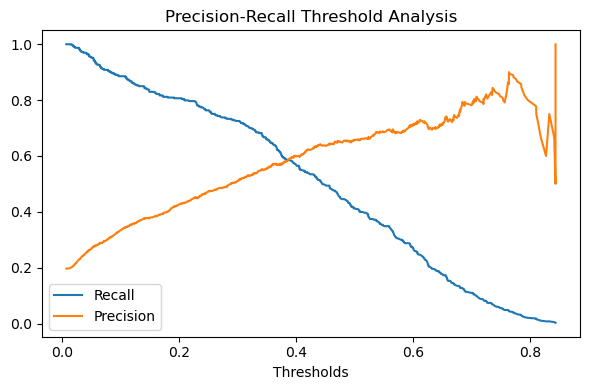

In [174]:
# Plot a precision-recall curve to visualise the precision and recall score at various thresholds. Identify the optimal threshold for recall
precision, recall, thresholds = churn.plot_precision_recall_curve(y_test, y_probs)
churn.get_optimal_threshold_for_recall(precision, recall, thresholds)

In [175]:
# Save the model
churn.save_model(optimal_model)

2025-08-12 14:16:37,162 - INFO - Model saved successfully


**Model Performance & Key Findings**



**Model Performance**

`Recall: 0.80`

`Precision: 0.43`

   - Recall - 0.80 which suggests that the model is catching 80% of actual churners, resulting in a low false negative rate. The model was built to optimise recall and minimise the false negative rate given the high cost of churners in the telco industry.
     
   - Precision - 0.43 Given the low cost of retention incentives compared to the the cost of churners, the precision score is a reasonable trade-off to prioritise a low false negative rate despite the high false positive rate. It is up to 5-10 times more expensive to replace a customer than retain an existing one through low cost retention efforts e.g. personalised emails/SMS/perks or offers. Lower precision is an acceptable trade-off in favour of higher recall, as the cost of missing a churner outweights false positives.
